In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#load dataset
dataset = pd.read_csv('./iris.csv')
dataset.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
#Create x and y variables
x = dataset.drop('species', axis=1).values
y = dataset['species'].values

# Train and Test
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,stratify=y,random_state=100)

#Scale x variables
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train2 = sc.fit_transform(x_train)
x_test2 = sc.fit_transform(x_test)

x_2 = sc.fit_transform(x)

#Import Models
from sklearn.svm import SVC

In [4]:
#Base SVM Model
from sklearn.metrics import classification_report, confusion_matrix  

for name,method in [('SVM', SVC())]: 
    method.fit(x_train2,y_train)
    predict = method.predict(x_test2)
    print('\nEstimator: {}'.format(name)) 
    print(confusion_matrix(y_test,predict))  
    print(classification_report(y_test,predict))      


Estimator: SVM
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00        10
   virginica       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [5]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_svm = Pipeline([('scl', StandardScaler()),
                    ('clf', SVC())])
pipeline.insert(0,pipe_svm)


# Set grid search params 

modelpara =[]

param_gridsvm = { 
           "clf__kernel" : ['linear', 'poly', 'rbf', 'sigmoid'],
           "clf__gamma" : [1e-1, 1e-2, 1e-3, 1e-4],
           "clf__C" : [1, 10, 100, 1000]}
modelpara.insert(0,param_gridsvm)     

In [6]:
#Define Plot for learning curve

from sklearn.model_selection import learning_curve

def plot_learning_curves(model):
    train_sizes, train_scores, test_scores = learning_curve(estimator=model,
                                                            X=x_train2, 
                                                            y=y_train,
                                                            cv=10,
                                                            train_sizes=np.linspace(.1,1,10),
                                                            scoring='accuracy',
                                                            n_jobs=1,random_state=100)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_mean,color='blue', marker='o', 
             markersize=5, label='training accuracy')
    plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5,
             label='validation accuracy')
    plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std,
                     alpha=0.15, color='green')
    plt.grid(True)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim([0.8, 1.01])
    plt.show()

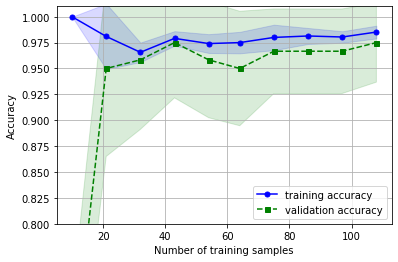

In [7]:
#Plot Learning Curve
plot_learning_curves(pipe_svm)

Model Evaluation - Accuracy Score
Support Vector Machines 0.98 +/- 0.04




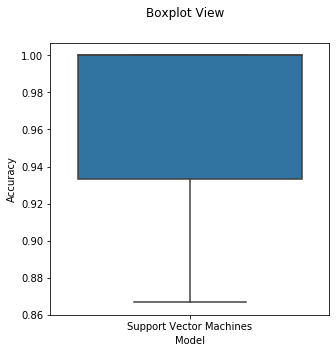

In [8]:
#Model Analysis
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

models=[]
models.append(('Support Vector Machines',SVC(gamma='auto')))

#Model Evaluation
results =[]
names=[]
scoring ='accuracy'
print('Model Evaluation - Accuracy Score')
for name, model in models:
    rkf=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
    cv_results = cross_val_score(model,x,y,cv=rkf,scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print('{} {:.2f} +/- {:.2f}'.format(name,cv_results.mean(),cv_results.std()))
print('\n')

#Boxpot View
fig = plt.figure(figsize=(5,5))
fig.suptitle('Boxplot View')
ax = fig.add_subplot(111)
sns.boxplot(data=results)
ax.set_xticklabels(names)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

In [9]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, n_jobs=-1, cv=cv2)
    gs_clf = gs_clf.fit(x_train, y_train)
    model = gs_clf.best_estimator_
    
    #Nested CV
    scoreACC = cross_val_score(gs_clf, x_2, y, 
                             scoring='accuracy', cv=5,
                             n_jobs= -1)
    
    scorePM = cross_val_score(gs_clf, x_2, y, 
                             scoring='precision_weighted', cv=5,
                             n_jobs= -1)
    
    scoreRM = cross_val_score(gs_clf, x_2, y, 
                             scoring='recall_weighted', cv=5,
                             n_jobs= -1)
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(x_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
        
    #Output Validation Statistics
    print('\nBest Parameters:',bestpara)
    
    #Confusion Matrix and Report
    target_names=['setosa','versicolor','virginica']
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
    
    #Nested CV
    print('\nNestedCV Accuracy(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreACC),np.std(scoreACC)))
    print('NestedCV Precision(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scorePM),np.std(scorePM)))
    print('NestedCV Recall(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scorePM),np.std(scoreRM)))   
    

In [10]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)


Optimized Model

Model Name: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Best Parameters: {'clf__C': 1, 'clf__gamma': 0.1, 'clf__kernel': 'sigmoid'}

 [[10  0  0]
 [ 0 10  0]
 [ 0  3  7]]

               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.77      1.00      0.87        10
   virginica       1.00      0.70      0.82        10

    accuracy                           0.90        30
   macro avg       0.92      0.90      0.90        30
weighted avg       0.92      0.90      0.90        30


NestedCV Accuracy(weighted) :0.97 +/-0.03 
NestedCV Precision(weighted) :0.97 +/-0.03 
NestedCV Recall(weighted) :0.97 +/-0.03 


Using TensorFlow backend.


Support Vector Machines

Permutation Importance




Weight,Feature
0.3067 ± 0.1543,petal_width
0.1933 ± 0.1067,petal_length
0.1000 ± 0.0730,sepal_width
0.0400 ± 0.0267,sepal_length


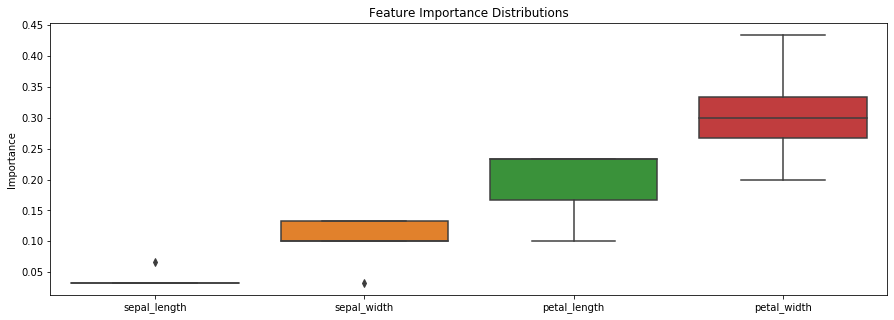

In [11]:
#Feature Importance
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display

for name, model in models:
    print(name)
    perm=PermutationImportance(model.fit(x_train2,y_train),random_state=100).fit(x_test2,y_test)
    features=dataset.drop('species', axis=1).columns
    print('\nPermutation Importance')
    print('\n')
    df=eli5.show_weights(perm,feature_names=dataset.drop('species', axis=1).columns.tolist())
    display(df)
    df2= pd.DataFrame(data=perm.results_,columns=features)
    fig = plt.figure(figsize=(15,5))
    sns.boxplot(data=df2).set(title='Feature Importance Distributions',
                             ylabel='Importance')
    plt.show()